## Chapter 1 - GARCH
Panit (Luke) Arunanondchai

In [22]:
rm(list=ls())
library(xts)
library(PerformanceAnalytics)

In [ ]:
# Install R in Jupyter Notebook
install.packages('IRkernel')  
IRkernel::installspec(user = FALSE)

In [ ]:
# If run in R studio
library(rstudioapi)
current_path <- getActiveDocumentContext()$path 
setwd(dirname(current_path ))

[1] "xts" "zoo"

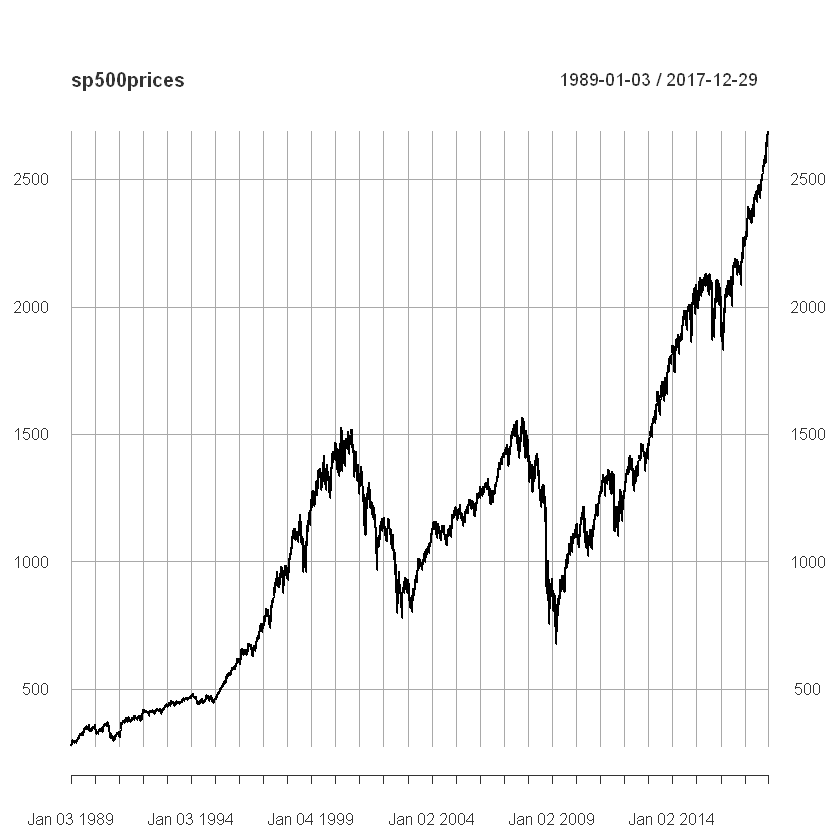

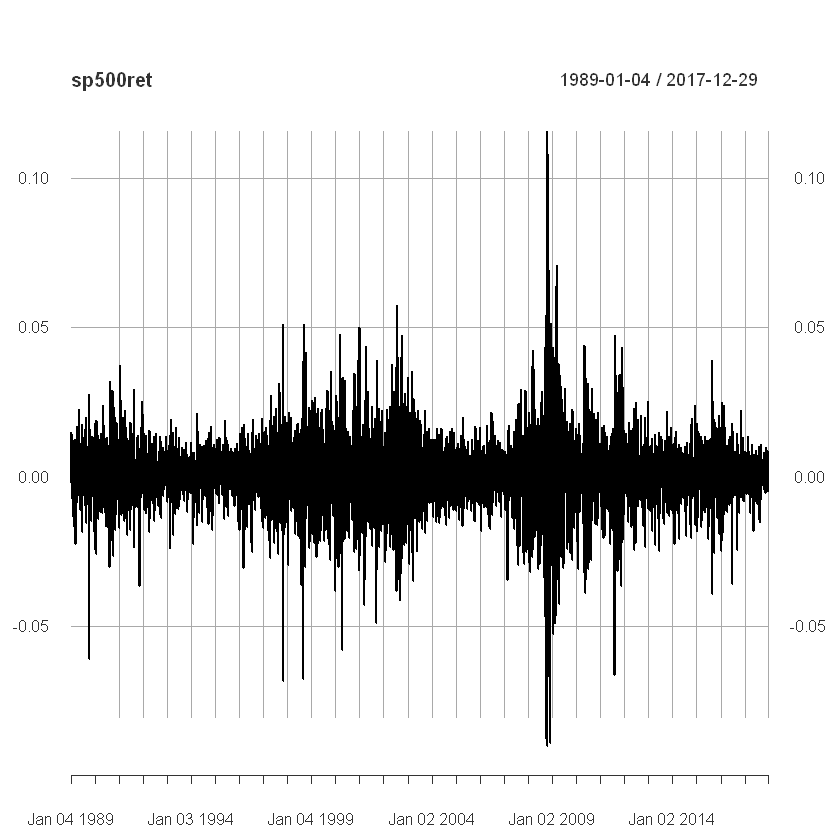

In [2]:
load("sp500prices.Rdata")
# Plot daily S&P 500 prices
plot(sp500prices)

# Compute daily returns
sp500ret <- CalculateReturns(sp500prices)[-1]

# Check the class of sp500ret
class(sp500ret)

# Plot daily returns
plot(sp500ret)

In [3]:
# Compute the daily standard deviation for the complete sample   
sd(sp500ret)

# Compute the annualized volatility for the complete sample
sqrt(252) * sd(sp500ret)

# Compute the annualized standard deviation for the year 2009 
sqrt(252) * sd(sp500ret["2009"])

# Compute the annualized standard deviation for the year 2017 
sqrt(252) * sd(sp500ret["2017"])

[1] 0.01099357

[1] 0.1745175

[1] 0.2728502

[1] 0.06685664

### Roll, roll, roll

You can visualize the time-variation in volatility by using the function **chart.RollingPerformance()** in the package PerformanceAnalytics. An important tuning parameter is the choice of the window length. The shorter the window, the more responsive the rolling volatility estimate is to recent returns. The longer the window, the smoother it will be. The function sd.annualized lets you compute annualized volatility under the assumption that the number of trading days in a year equals the number specified in the scale argument.

In this exercise you need to complete the code to compute the rolling estimate of annualized volatility for the daily S&P 500 returns in sp500ret for the period 2005 until 2017.

- Load the package PerformanceAnalytics.
- Compute the one month estimate, setting the scale argument to the number of trading days in a year.
- Compute the three months estimate, setting the scale argument to the number of trading days in a year.

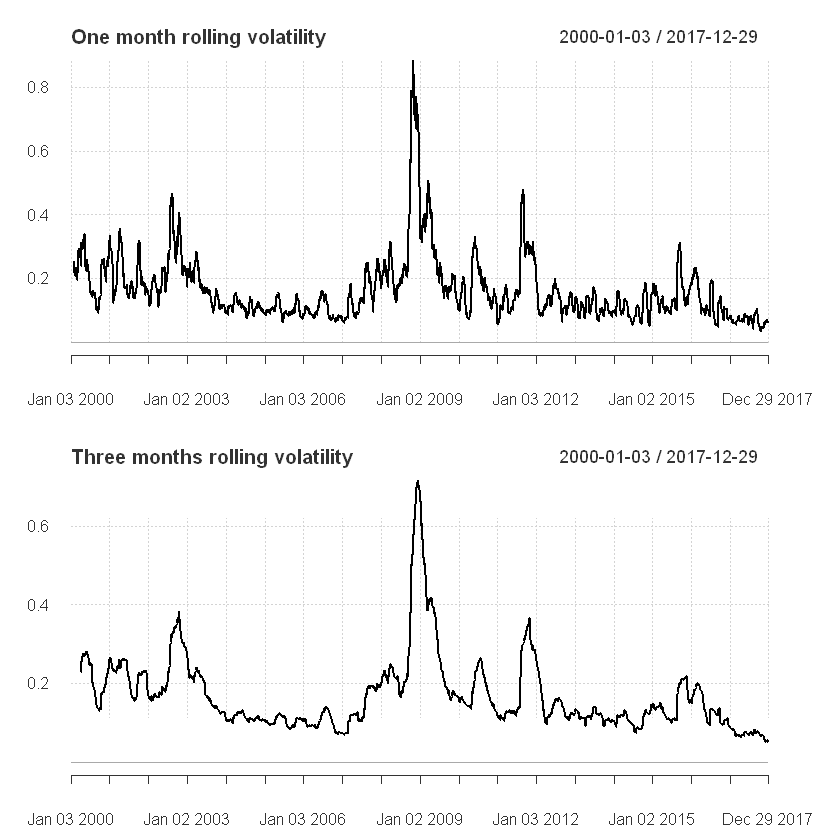

In [4]:
# Load the package PerformanceAnalytics
library(PerformanceAnalytics)

# Showing two plots on the same figure
par(mfrow=c(2,1)) 

# Compute the rolling 1 month estimate of annualized volatility
chart.RollingPerformance(R = sp500ret["2000::2017"], width = 22,
     FUN = "sd.annualized", scale = 252, main = "One month rolling volatility")

# Compute the rolling 3 months estimate of annualized volatility
chart.RollingPerformance(R = sp500ret["2000::2017"], width = 66,
     FUN = "sd.annualized", scale = 252, main = "Three months rolling volatility")

Notice how smooth the line is for a period of 3 months compared to 1 month.

### GARCH(1,1) reaction to one-off shocks

The GARCH approach models the variance using the prediction errors et (also called shocks or unexpected returns). The parameter α determines the reactivity to $e^2_t$ , while β is the weight on the previous variance prediction.

In this exercise, we consider the series of squared prediction errors e2 <- c(10,25,rep(10,20)). We plot the variance for:

α=0.1 and β=0.8
α=0.19 and β=0.8
α=0.1 and β=0.89.
We set ω such that the long term variance is 10.

Which statement about the effect of the shock on the variance is wrong?
Possible Answers
- The variance shoots up and then returns to ω/(1−α−β).
- The larger is α, the larger is the immediate impact of the shock.
- Holding fixed α, the larger is β, the longer is the duration of the impact.
- **The triangles show the variance when α=0.1 and β=0.8.**

### Prediction errors

Under the GARCH model, the variance is driven by the square of the prediction errors e=R−μ. In order to calculate a GARCH variance, you thus need to first compute the prediction errors. For daily returns, it is common practice to set μ equal to the sample average.

You're going to implement this and then verify that there is a large positive autocorrelation in the absolute value of the prediction errors. Positive autocorrelation reflects the presence of volatility clusters. When volatility is above average, it stays above average for some time. When volatility is low, it stays low for some time.

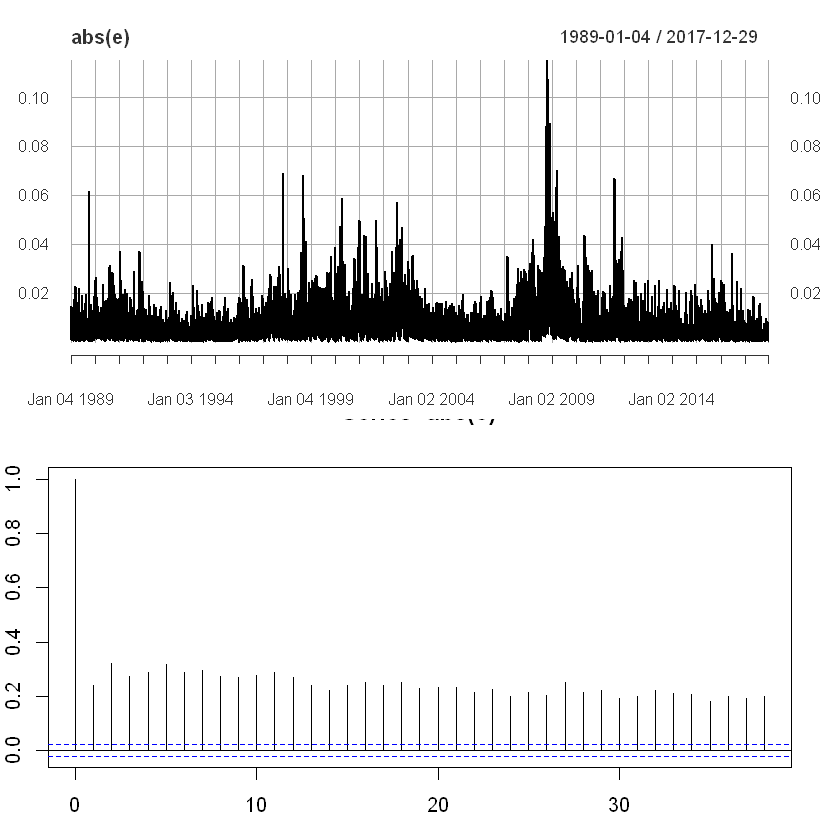

In [5]:
# Compute the mean daily return
m <- mean(sp500ret)

# Define the series of prediction errors
e <- sp500ret - m

# Plot the absolute value of the prediction errors
par(mfrow = c(2,1),mar = c(3, 2, 2, 2))
plot(abs(e))

# Plot the acf of the absolute prediction errors after removing missing values
# acf(abs(e[complete.cases(e),]))
acf(abs(e))

Note the waves in the absolute prediction errors in the top plot. They correspond to the presence of high and low volatility clusters. In the bottom plot, you can see the large positive autocorrelations in the absolute prediction errors. Almost all of them are above 0.2.

### The recursive nature of the GARCH variance

Under the GARCH(1,1) equation the predicted variance is determined by the squared surprise in return and the previous variance prediction: 

$$\sigma^2_t = \omega + \sigma(R_{t-1}-\mu_{t-1})^2 + \beta\sigma^2_{t-1} $$

You can implement this using a loop (refer to the slides if you don't remember the loop structure from the video).

Let's do this for the S&P 500 daily returns. The variables omega, alpha, beta, nobs, e2 and predvar are already loaded in your R environment.

In [8]:
nobs = nrow(sp500ret)
omega = 1.208585e-05
alpha = 0.1
beta = 0.8
e2 = e^2

predvar = rep(NA,nobs)

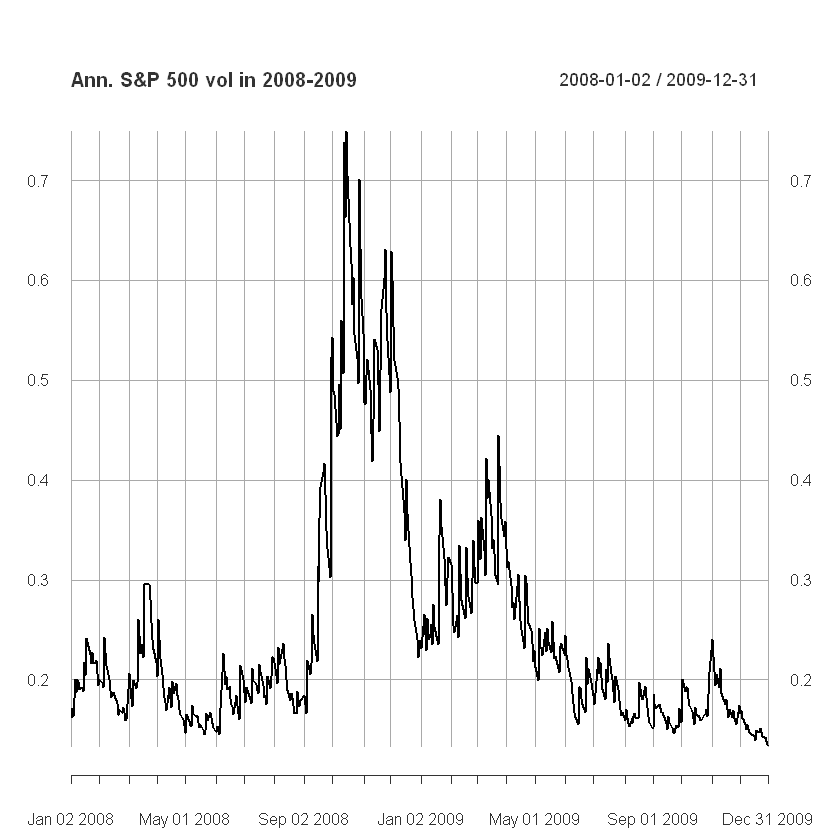

In [9]:
# Compute the predicted variances
predvar[1] <- var(sp500ret) 
for(t in 2:nobs){
   predvar[t] <- omega + alpha * e2[t-1] + beta * predvar[t-1]
}

# Create annualized predicted volatility
ann_predvol <- xts(sqrt(252) * sqrt(predvar), order.by = time(sp500ret))

# Plot the annual predicted volatility in 2008 and 2009
plot(ann_predvol["2008::2009"], main = "Ann. S&P 500 vol in 2008-2009")

The large spike in volatility in mid september 2008 is due to the collapse of Lehman Brothers on September 15, 2008.

### Specify and taste the GARCH model flavors

In the next chapters, you will see that GARCH models come in many flavors. You thus need to start off by specifying the mean model, the variance model and the error distribution that you want to use. The best model to use is application-specific. A realistic GARCH analysis thus involves specifying, estimating and testing various GARCH models.

In R, this is simple thanks to the rugarch package of Alexios Ghalanos. This package has already been loaded for you. You will apply it to analyze the daily returns in sp500ret.

In [16]:
# install.packages('rugarch')
library(rugarch)
citation("rugarch")


When using rugarch in publications, please cite:

To cite the rugarch package, please use:

  Alexios Ghalanos (2019). rugarch: Univariate GARCH models. R package
  version 1.4-1.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {rugarch: Univariate GARCH models.},
    author = {Alexios Ghalanos},
    year = {2019},
    note = {R package version 1.4-1.},
  }


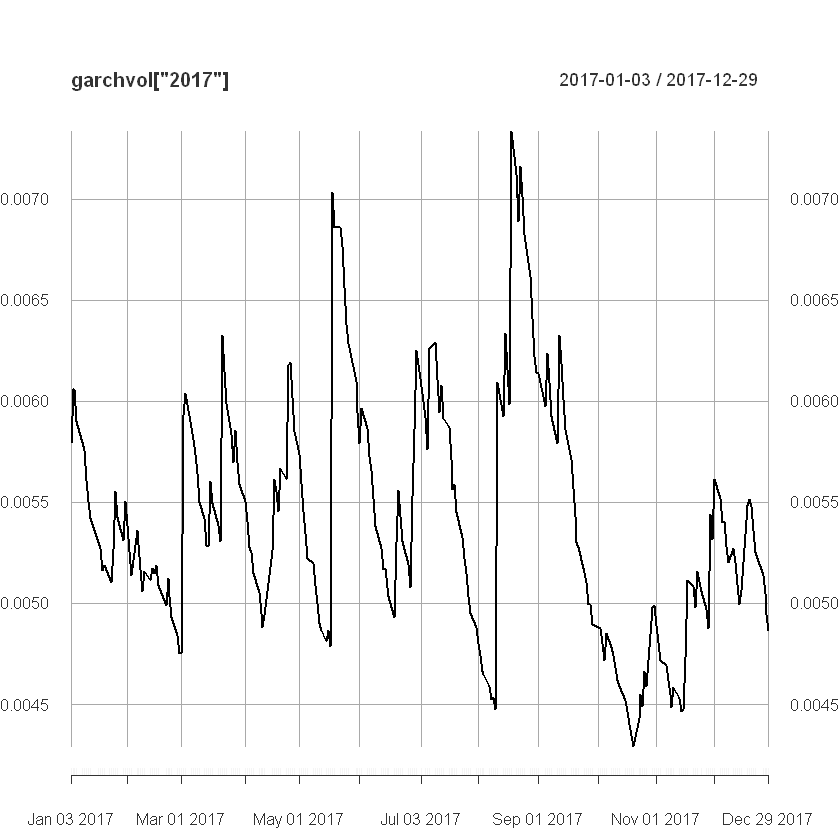

In [17]:
# Specify a standard GARCH model with constant mean
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                 variance.model = list(model = "sGARCH"), 
                 distribution.model = "norm")

# Estimate the model
garchfit <- ugarchfit(data = sp500ret, spec = garchspec)

# Use the method sigma to retrieve the estimated volatilities 
garchvol <- sigma(garchfit) 

# Plot the volatility for 2017
plot(garchvol["2017"])

In [19]:
tail(garchvol)

                  [,1]
2017-12-21 0.005364012
2017-12-22 0.005252819
2017-12-26 0.005142349
2017-12-27 0.005051926
2017-12-28 0.004947569
2017-12-29 0.004862908

Notice the typical GARCH behavior: after a large unexpected return, volatility spikes upwards and then decays away until there is another shock. 

### Out-of-sample forecasting

The garchvol series is the series of predicted volatilities for each of the returns in the observed time series sp500ret. For decision making, it is the volatility of the future (not yet observed) return that matters. You get it by applying the ugarchforecast() function to the output from ugarchfit() In forecasting, we call this the out-of-sample volatility forecasts, as they involve predictions of returns that have not been used when estimating the GARCH model.

This exercise uses the garchfit and garchvol objects that you created in the previous exercise. If you need to check which arguments a function takes, you can use ?name_of_function in the Console to access the documentation.

In [20]:
# Compute unconditional volatility
sqrt(uncvariance(garchfit))

# Print last 10 ones in garchvol
tail(garchvol, 10)

# Forecast volatility 5 days ahead and add 
garchforecast <- ugarchforecast(fitORspec = garchfit, 
                     n.ahead = 5)

# Extract the predicted volatilities and print them
print(sigma(garchforecast))

[1] 0.01056519

                  [,1]
2017-12-15 0.005064733
2017-12-18 0.005485695
2017-12-19 0.005516094
2017-12-20 0.005483721
2017-12-21 0.005364012
2017-12-22 0.005252819
2017-12-26 0.005142349
2017-12-27 0.005051926
2017-12-28 0.004947569
2017-12-29 0.004862908

     2017-12-29
T+1 0.005034754
T+2 0.005127582
T+3 0.005217770
T+4 0.005305465
T+5 0.005390797


### Volatility targeting in tactical asset allocation

GARCH volatility predictions are of direct practical use in portfolio allocation. According to the two-fund separation theorem of James Tobin, you should invest a proportion w of your wealth in a risky portfolio and the remainder in a risk free asset, like a US Treasury bill.

When you target a portfolio with 5% annualized volatility, and the annualized volatility of the risky asset is $\sigma_t$, then you should invest 0.05/$\sigma_t$ in the risky asset.

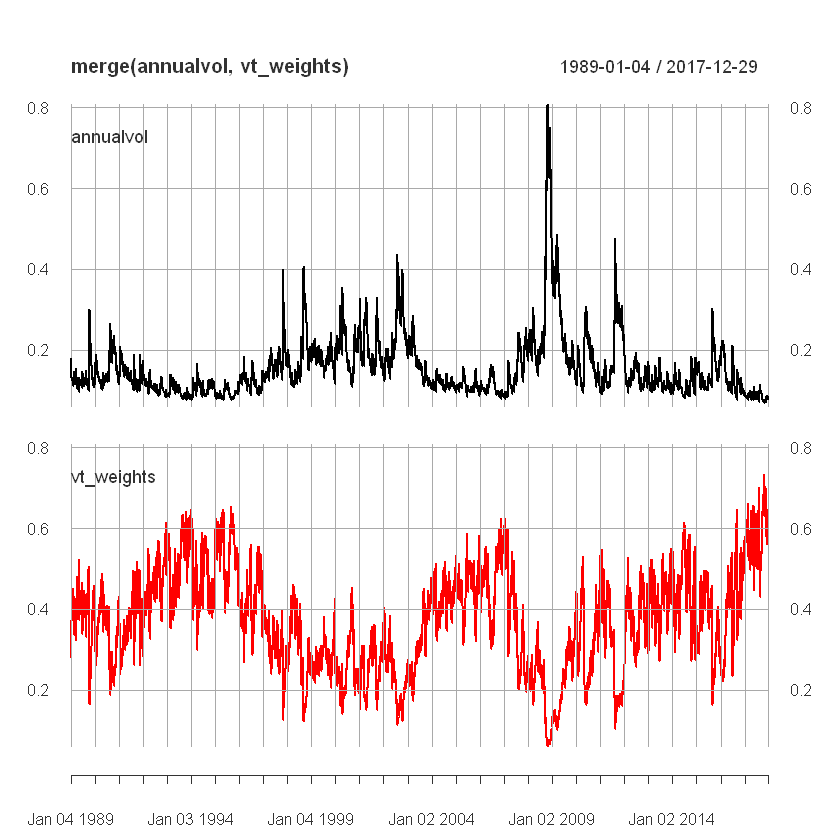

In [21]:
# Compute the annualized volatility
annualvol <- sqrt(252) * sigma(garchfit)

# Compute the 5% vol target weights  
vt_weights <- 0.05 / annualvol

# Compare the annualized volatility to the portfolio weights in a plot
plot(merge(annualvol, vt_weights), multi.panel = TRUE)

In 2018, the model recommends a portfolio exposure to the S&P 500 of about 60%.